In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import string
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
import os
os.getcwd()

'/content'

Creating Vocabulary list

In [ ]:
def add_doc_to_vocab(filename,vocab):
  doc=load_doc(filename)
  tokens=clean_doc(doc)
  vocab.update(tokens)

In [ ]:
def process_docs(directory,vocab):
  for filename in os.listdir(directory):
    path =directory+'/'+filename
    add_doc_to_vocab(path,vocab)

In [ ]:
def save_list(lines,filename):
  data='\n'.join(lines)
  file=open(filename,'w')
  file.write(data)
  file.close()

In [ ]:
vocab=Counter()
process_docs('txt_sentoken/pos',vocab)
process_docs('txt_sentoken/neg',vocab)
print(len(vocab))
min_occurane=5
tokens=[k for k,c in vocab.items() if c>=min_occurane]
print(len(tokens))
save_list(tokens,'vocab.txt')

Selecting modes of the model for using Tokenier

In [7]:
def load_doc(filename):
  file=open(filename,'r')
  text=file.read()
  file.close()
  return text

In [8]:
def clean_doc(doc):
  doc=doc.split()
  re_punc=re.compile('[%s]' %re.escape(string.punctuation))
  tokens=[re_punc.sub('',w) for w in doc]
  re_html=re.compile('<.*?>')
  tokens=[re_html.sub('',w) for w in tokens]
  tokens=[word for word in tokens if word.isalpha()]
  stop_words=set(stopwords.words('english'))
  tokens=[w for w in tokens if not w in stop_words]
  tokens=[word for word in tokens if len(word) > 1]
  return tokens

Developing the Model

In [9]:
def doc_to_line(filename,vocab):
  doc=load_doc(filename)
  tokens=clean_doc(doc)
  tokens=[w for w in tokens if w in vocab]
  return ' '.join(tokens)

In [11]:
def process_docs(directory,vocab,is_train):
  lines=list()
  for filename in os.listdir(directory):
    if is_train and filename.startswith('cv9'):
      continue
    if not is_train and not filename.startswith('cv9'):
      continue
    path =directory+'/'+filename
    line=doc_to_line(path,vocab)
    lines.append(line)
  return lines

In [12]:
def load_clean_dataset(vocab,is_train):
  neg=process_docs('txt_sentoken/neg',vocab,is_train)
  pos=process_docs('txt_sentoken/pos',vocab,is_train)
  docs=neg+pos
  labels=[0 for _ in range(len(neg))] +[1 for _ in range(len(pos))]
  return np.array(docs),np.array(labels)

In [13]:
def prepare_data(train_docs,test_docs,mode):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(train_docs)
  X_train=tokenizer.texts_to_matrix(train_docs,mode=mode)
  X_test=tokenizer.texts_to_matrix(test_docs,mode=mode)
  return X_train,X_test

In [50]:
def define_models(n_words):
  model=Sequential()
  model.add(Dense(35,input_shape=(n_words,),activation='relu'))
  model.add(Dropout(.5))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model

In [27]:
def evaluate_mode(Xtrain,ytrain,Xtest,ytest):
  scores=list()
  n_repeats=10
  n_words=Xtest.shape[1]
  for i in range(n_repeats):
    model=define_models(n_words)
    model.fit(Xtrain,ytrain,epochs=10,verbose=0)
    _,acc=model.evaluate(Xtest,ytest,verbose=0)
    scores.append(acc)
    print('%d accuracy: %s' %((i+1),acc))
  return scores

1 accuracy: 0.925000011920929
2 accuracy: 0.9150000214576721
3 accuracy: 0.9200000166893005
4 accuracy: 0.9049999713897705
5 accuracy: 0.925000011920929
6 accuracy: 0.8949999809265137
7 accuracy: 0.8949999809265137
8 accuracy: 0.9449999928474426
9 accuracy: 0.9150000214576721
10 accuracy: 0.925000011920929
1 accuracy: 0.875
2 accuracy: 0.8799999952316284
3 accuracy: 0.8700000047683716
4 accuracy: 0.8949999809265137
5 accuracy: 0.8949999809265137
6 accuracy: 0.8899999856948853
7 accuracy: 0.8849999904632568
8 accuracy: 0.8949999809265137
9 accuracy: 0.8799999952316284
10 accuracy: 0.8899999856948853
1 accuracy: 0.8849999904632568
2 accuracy: 0.8799999952316284
3 accuracy: 0.8999999761581421
4 accuracy: 0.8600000143051147
5 accuracy: 0.8899999856948853
6 accuracy: 0.8700000047683716
7 accuracy: 0.8550000190734863
8 accuracy: 0.875
9 accuracy: 0.8999999761581421
10 accuracy: 0.8799999952316284
1 accuracy: 0.8999999761581421
2 accuracy: 0.8949999809265137
3 accuracy: 0.9100000262260437
4 a

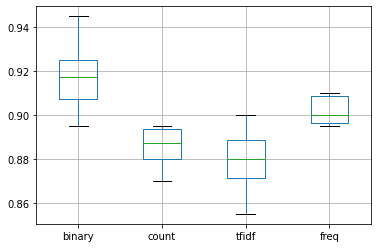

In [14]:
filename='vocab.txt'
vocab=load_doc(filename)
vocab=set(vocab.split())
train_docs,ytrain=load_clean_dataset(vocab,True)
test_docs,ytest=load_clean_dataset(vocab,False)
modes=['binary','count','tfidf','freq']
results=pd.DataFrame()
for mode in modes:
  X_train,X_test=prepare_data(train_docs,test_docs,mode)
  results[mode]=evaluate_mode(X_train,ytrain,X_test,ytest)
print(results.describe())
results.boxplot()
plt.show()